In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Dense
# import gym
from collections import deque
import seaborn as sns
import random

In [3]:
bms_min = pd.read_csv(f"BigData//DB_05_gen_bms_min.gzip", compression="gzip")

import pandas as pd

# Assuming df is your DataFrame


def provide_df(bms_min):
    df = bms_min.copy()

    # Step 1: Create the Timestamp Column
    # Convert mana_day, mana_hh, mana_mm to string, concatenate them, and convert to datetime
    df['timestamp'] = pd.to_datetime(df['mana_day'].astype(str)                 + ' ' +
                                     df['mana_hh']. astype(str).str.zfill(2)    + ':' +
                                     df['mana_mm']. astype(str).str.zfill(2), 
                                     format='%Y%m%d %H:%M')

    # Reorder columns to place timestamp at the beginning
    df = df[['timestamp'] + [col for col in df.columns if col != 'timestamp']]

    # Step 2: Sort the DataFrame
    df.sort_values(by='timestamp', inplace=True)

    # Step 3: Reset the index
    df.reset_index(drop=True, inplace=True)


    return df

df=provide_df(bms_min)

In [4]:
# Converting the 'timestamp' column to datetime and setting it as the index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Resampling the data to daily frequency for 'charging', 'discharging', and 'soc' columns
hourly_df = df[['now_kw','soc']].resample('H').mean()

# Display the first few rows of the resampled dataframe
hourly_df.head()
df=provide_df(bms_min)

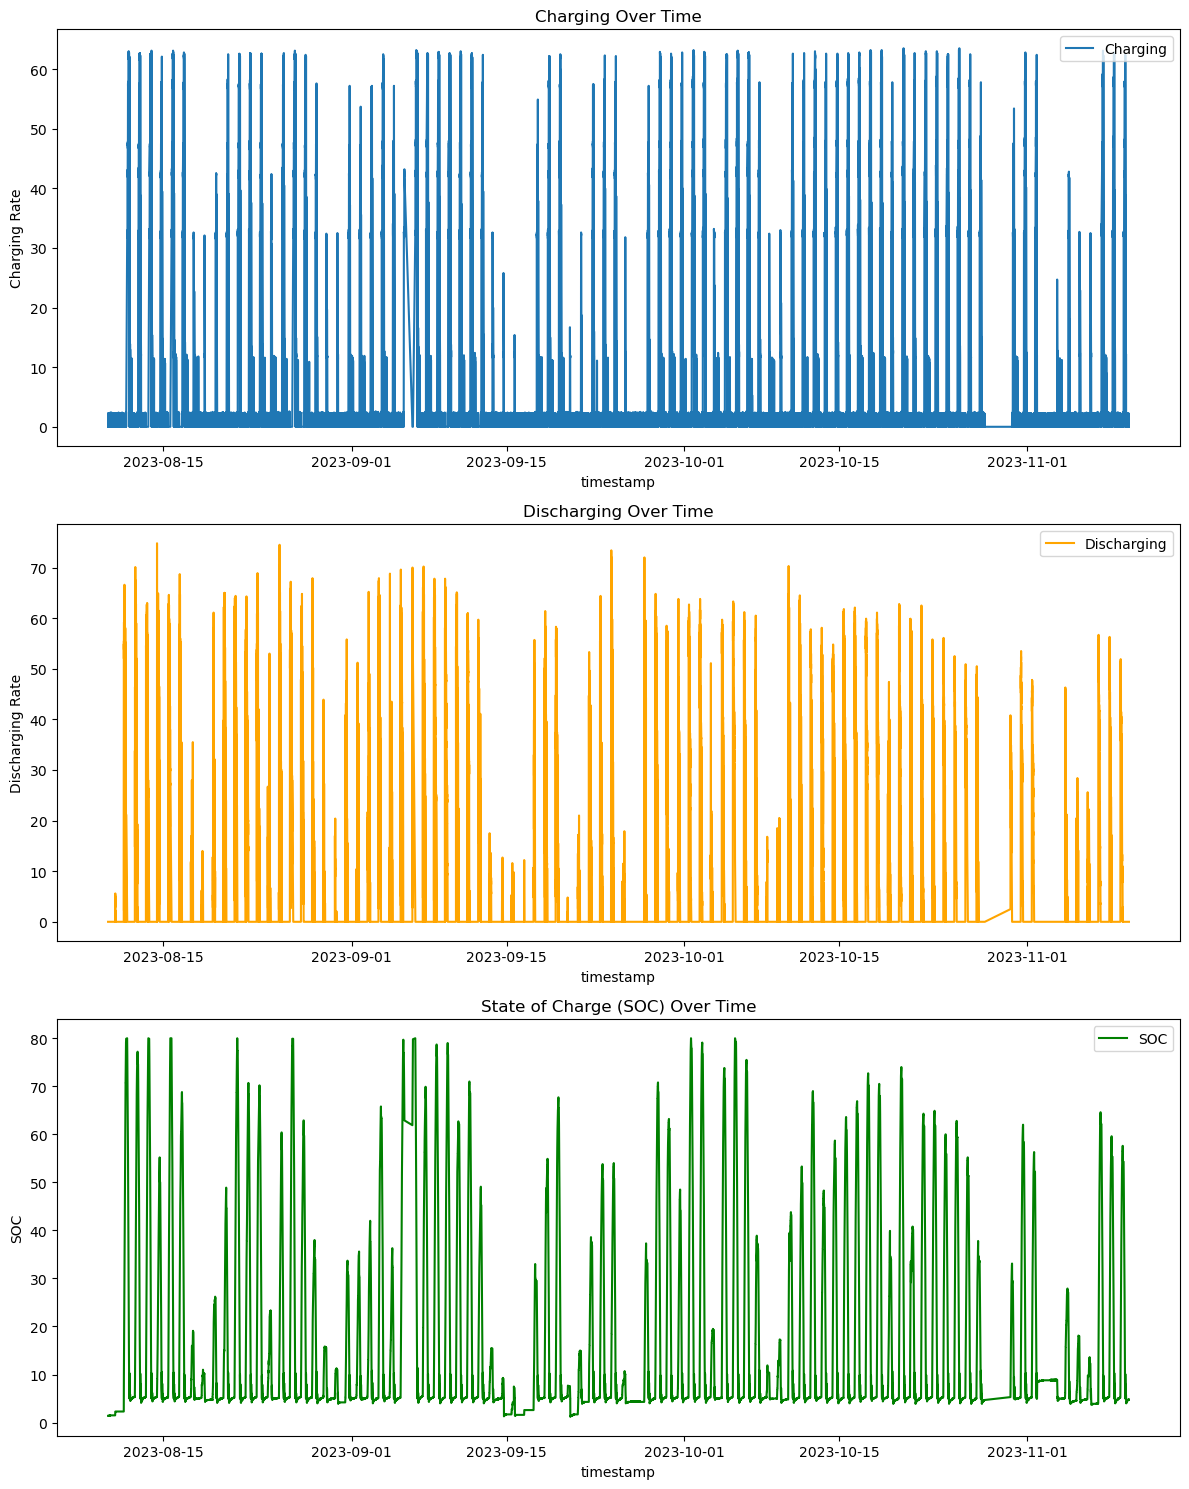

(          Unnamed: 0         now_kw            soc       charging  \
 count  127480.000000  127480.000000  127480.000000  127480.000000   
 mean    64466.004212       1.949037      16.669724       6.722513   
 std     37005.859703      21.335443      19.948902      14.954427   
 min         0.000000     -74.800000       1.200000       0.000000   
 25%     32389.750000       0.000000       4.800000       0.000000   
 50%     64563.500000       0.000000       5.200000       0.000000   
 75%     96518.250000       2.200000      22.800000       2.200000   
 max    128388.000000      63.500000      80.000000      63.500000   
 
          discharging      discision  
 count  127480.000000  127480.000000  
 mean        4.773477      -0.474396  
 std        12.937784       0.880315  
 min         0.000000      -1.000000  
 25%         0.000000      -1.000000  
 50%         0.000000      -1.000000  
 75%         0.000000       1.000000  
 max        74.800000       1.000000  ,
 None)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
file_path = 'df_few_cleaned.csv'
data = pd.read_csv(file_path)
# Statistical summary of the dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the timestamp to a datetime object for easier analysis
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Set the timestamp as the index
data.set_index('timestamp', inplace=True)

# Basic statistics of the dataset
basic_stats = data.describe()

# Plotting trends over time for charging, discharging, and SOC
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
sns.lineplot(ax=axes[0], data=data['charging'], label='Charging')
axes[0].set_title('Charging Over Time')
axes[0].set_ylabel('Charging Rate')

sns.lineplot(ax=axes[1], data=data['discharging'], label='Discharging', color='orange')
axes[1].set_title('Discharging Over Time')
axes[1].set_ylabel('Discharging Rate')

sns.lineplot(ax=axes[2], data=data['soc'], label='SOC', color='green')
axes[2].set_title('State of Charge (SOC) Over Time')
axes[2].set_ylabel('SOC')

plt.tight_layout()

basic_stats, plt.show()


In [6]:
from sklearn.preprocessing import MinMaxScaler

# # Assuming 'data' is your DataFrame with relevant features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(daily_df)


In [7]:
# Assuming 'df' is the original DataFrame and 'now_kw' is the target variable

# Selecting the 'now_kw' column as the target
target_data = df[['now_kw']]

# Scaling the target data
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target_data = target_scaler.fit_transform(target_data)

# The function to create dataset remains the same
def create_target_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Creating the dataset for LSTM with the target data
X_target, y_target = create_target_dataset(scaled_target_data, 60)

# Splitting the dataset into training and testing sets for the target
test_size = int(len(X_target) * 0.2)
train_size = len(X_target) - test_size
X_train_target, X_test_target = X_target[0:train_size], X_target[train_size:len(X_target)]
y_train_target, y_test_target = y_target[0:train_size], y_target[train_size:len(y_target)]

X_train_target.shape, X_test_target.shape, y_train_target.shape, y_test_target.shape


((419027, 60), (104756, 60), (419027,), (104756,))

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Building the LSTM model
model = Sequential()

# Adding the first LSTM layer with some Dropout regularization
# Adjust the number of units according to your dataset and complexity
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_target.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer with some Dropout regularization
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')


# Training the model
# Note: Adjust epochs and batch_size based on your dataset size and computational resources
history=model.fit(X_train_target, y_train_target, epochs=100, batch_size=1024, validation_data=(X_test_target, y_test_target))



Epoch 1/100
410/410 [==============================] - 12s 18ms/step - loss: 4.0314e-06 - val_loss: 1.7791e-07
Epoch 2/100
410/410 [==============================] - 6s 15ms/step - loss: 2.7027e-06 - val_loss: 8.7367e-08
Epoch 3/100
410/410 [==============================] - 6s 16ms/step - loss: 2.7172e-06 - val_loss: 3.9584e-07
Epoch 4/100
410/410 [==============================] - 6s 16ms/step - loss: 2.7416e-06 - val_loss: 7.6371e-08
Epoch 5/100
410/410 [==============================] - 6s 15ms/step - loss: 2.7844e-06 - val_loss: 1.1624e-07
Epoch 6/100
410/410 [==============================] - 6s 16ms/step - loss: 2.6543e-06 - val_loss: 7.2764e-08
Epoch 7/100
410/410 [==============================] - 6s 16ms/step - loss: 2.7577e-06 - val_loss: 7.5687e-08
Epoch 8/100
410/410 [==============================] - 6s 15ms/step - loss: 2.6502e-06 - val_loss: 6.7083e-08
Epoch 9/100
410/410 [==============================] - 7s 16ms/step - loss: 2.6629e-06 - val_loss: 8.6829e-08
Epoch 10/

Epoch 75/100
410/410 [==============================] - 7s 16ms/step - loss: 2.5183e-06 - val_loss: 5.6953e-08
Epoch 76/100
410/410 [==============================] - 7s 16ms/step - loss: 2.5049e-06 - val_loss: 6.0634e-08
Epoch 77/100
410/410 [==============================] - 6s 15ms/step - loss: 2.4965e-06 - val_loss: 5.6842e-08
Epoch 78/100
410/410 [==============================] - 6s 16ms/step - loss: 2.4944e-06 - val_loss: 5.6426e-08
Epoch 79/100
410/410 [==============================] - 6s 16ms/step - loss: 2.4958e-06 - val_loss: 2.5499e-07
Epoch 80/100
410/410 [==============================] - 6s 16ms/step - loss: 2.5056e-06 - val_loss: 5.5395e-08
Epoch 81/100
410/410 [==============================] - 7s 16ms/step - loss: 2.4930e-06 - val_loss: 5.5759e-08
Epoch 82/100
410/410 [==============================] - 6s 16ms/step - loss: 2.4986e-06 - val_loss: 5.8799e-08
Epoch 83/100
410/410 [==============================] - 7s 16ms/step - loss: 2.5027e-06 - val_loss: 5.6309e-08
E

In [9]:
model.save(f'AI5_model.h5')

In [10]:
model=tf.keras.models.load_model('AI5_model.h5')

In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Making predictions
predicted_now_kw = model.predict(X_test_target)

# Inverting the scaling for prediction
predicted_now_kw = target_scaler.inverse_transform(predicted_now_kw)
actual_now_kw = target_scaler.inverse_transform(y_test_target.reshape(-1, 1))

# Calculating RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(actual_now_kw, predicted_now_kw))
print(f'Root Mean Squared Error: {rmse}')


3274/3274 [==============================] - 13s 4ms/step
Root Mean Squared Error: 5.8380640985359005


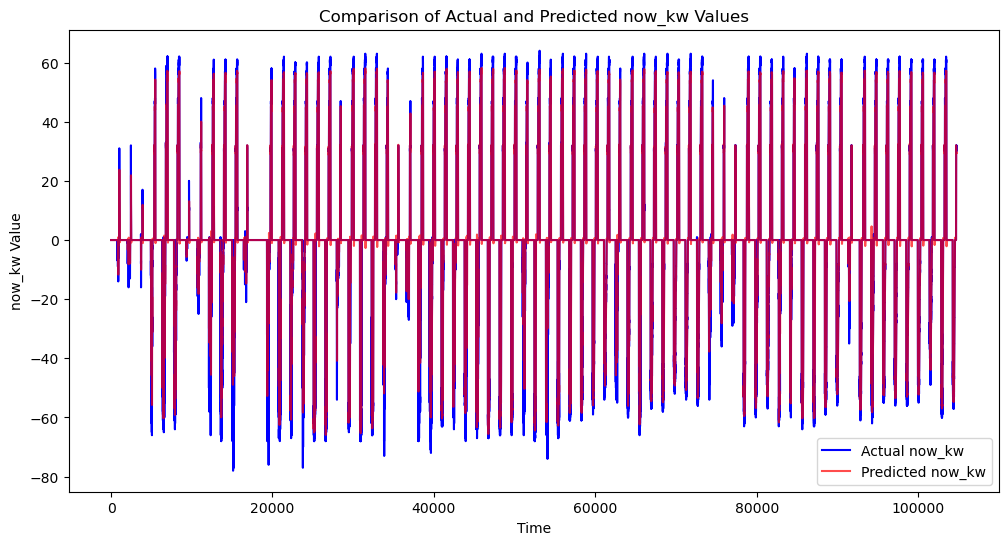

In [12]:
import matplotlib.pyplot as plt

# Assuming predicted_now_kw and actual_now_kw are arrays containing the predicted and actual values, respectively

# Plotting the actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(actual_now_kw, label='Actual now_kw', color='blue')
plt.plot(predicted_now_kw, label='Predicted now_kw', color='red', alpha=0.7)
plt.title('Comparison of Actual and Predicted now_kw Values')
plt.xlabel('Time')
plt.ylabel('now_kw Value')
plt.legend()
plt.show()


In [14]:
df_main=df[['timestamp','now_kw', 'soc']]

In [15]:
df_main

,timestamp,now_kw,soc
0,2022-11-25 00:00:00,0.0,10.0
1,2022-11-25 00:01:00,0.0,10.0
2,2022-11-25 00:02:00,0.0,10.0
3,2022-11-25 00:03:00,0.0,10.0
4,2022-11-25 00:04:00,0.0,10.0
...,...,...,...
523839,2023-11-25 17:55:00,31.0,69.9
523840,2023-11-25 17:56:00,31.0,69.8
523841,2023-11-25 17:57:00,31.0,69.5
523842,2023-11-25 17:58:00,31.0,69.4


In [106]:
def get_row(last_rows,prev_opt_soc):
    
    now_kw=np.expand_dims(last_rows['now_kw'].values, axis=0)
#     char_rate=np.mean(np.abs(now_kw[now_kw>=0]))
#     dis_rate=np.mean(np.abs(now_kw[now_kw>=0]))
    
    
#     print(char_rate)
#     ff
    
    pred_kw=model.predict(now_kw)
    char_rate=np.abs(np.squeeze(pred_kw))
    dis_rate=-np.abs(np.squeeze(pred_kw))
    if char_rate <1:
        char_rate = 1
        dis_rate = -1
    last_row=last_rows.iloc[-1]
    

    
    un_soc=last_row['soc']
    soc=prev_opt_soc
#     print(soc)
#     ff
    now_kw=last_row['now_kw']
    time=last_row['timestamp']
    
    opt_soc=soc
    if soc > 80:
        model_dis='discharge'
        if np.abs(dis_rate) < 5:
            dis_rate=-10
        if np.squeeze(pred_kw)==0 or np.abs(np.squeeze(pred_kw))<1:
        
            dis_rate=-2
        opt_soc=soc+dis_rate
    elif soc > 20 and soc <= 80:
    
        model_dis='safe'
        if soc > 70 and soc <= 80:
            opt_soc=soc-5
        elif np.squeeze(pred_kw)==0 or np.abs(np.squeeze(pred_kw))<1:
            opt_soc=soc+2
        else:
            opt_soc=soc+np.squeeze(pred_kw)
        
    elif soc<=20:
#         print(f'xx {char_rate}')
        model_dis='charge'
        if char_rate < 10:
            char_rate = 10
        elif pred_kw == 0:
        
            char_rate=2
#         print(char_rate)
        opt_soc=soc+char_rate
 
    print(f'timestamp: {time} current soc {un_soc} optimize soc {opt_soc} optimal discision: {model_dis}')
    return opt_soc,un_soc
    
    

In [107]:
df_main.dropna(inplace=True)

C:\ProgramData\Anaconda3\envs\py37gpu\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [108]:
opt_socs=[]
socs=[]
for i in range(len(df_main)):
    if len(opt_socs)==0:
        prev_soc=df_main.iloc[i:i+60].iloc[-1]['soc']
    
    else:
        prev_soc=opt_socs[-1]
    opt_soc,soc=get_row(df_main.iloc[i:i+60],prev_soc)
    opt_socs.append(opt_soc)
    socs.append(soc)
    
    

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 00:59:00 current soc 10.0 optimize soc 20.0 optimal discision: charge
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-25 01:00:00 current soc 10.0 optimize soc 30.0 optimal discision: charge
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 01:01:00 current soc 10.0 optimize soc 32.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-25 01:02:00 current soc 10.0 optimize soc 34.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-25 01:03:00 current soc 10.0 optimize soc 36.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 01:04:00 current soc 10.0 optimize soc 38.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 01:05:00 current soc 10.0 optimize soc 40.0 optimal discision: safe
1/

1/1 [==============================] - 0s 20ms/step
timestamp: 2022-11-25 01:57:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 01:58:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 01:59:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-25 02:00:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-25 02:01:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 34ms/step
timestamp: 2022-11-25 02:02:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-25 02:03:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-25 02:55:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 36ms/step
timestamp: 2022-11-25 02:56:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-25 02:57:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-25 02:58:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-25 02:59:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-25 03:00:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 03:01:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 20ms/step
timestamp: 2022-11-25 03:53:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-25 03:54:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 33ms/step
timestamp: 2022-11-25 03:55:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-25 03:56:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-25 03:57:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-25 03:58:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-25 03:59:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 37ms/step
timestamp: 2022-11-25 04:51:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 04:52:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-25 04:53:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 04:54:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-25 04:55:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-25 04:56:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-25 04:57:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 36ms/step
timestamp: 2022-11-25 05:49:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 40ms/step
timestamp: 2022-11-25 05:50:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-25 05:51:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 36ms/step
timestamp: 2022-11-25 05:52:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-25 05:53:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-25 05:54:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 05:55:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 06:47:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 06:48:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 06:49:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 06:50:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 47ms/step
timestamp: 2022-11-25 06:51:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-25 06:52:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 06:53:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-25 07:45:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 33ms/step
timestamp: 2022-11-25 07:46:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-25 07:47:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-25 07:48:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-25 07:49:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 07:50:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-25 07:51:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-25 08:43:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 08:44:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-25 08:45:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 08:46:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-25 08:47:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-25 08:48:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-25 08:49:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 09:41:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 09:42:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 35ms/step
timestamp: 2022-11-25 09:43:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-25 09:44:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 09:45:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 09:46:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-25 09:47:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 10:39:00 current soc 19.9 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 10:40:00 current soc 20.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 33ms/step
timestamp: 2022-11-25 10:41:00 current soc 20.4 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-25 10:42:00 current soc 20.8 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 10:43:00 current soc 20.9 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 10:44:00 current soc 21.2 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-25 10:45:00 current soc 21.6 optimize soc 66.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-25 11:37:00 current soc 35.6 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 11:38:00 current soc 35.9 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-25 11:39:00 current soc 36.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 11:40:00 current soc 36.4 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 43ms/step
timestamp: 2022-11-25 11:41:00 current soc 36.7 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 11:42:00 current soc 36.9 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 11:43:00 current soc 37.2 optimize soc 70.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-25 12:35:00 current soc 48.8 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-25 12:36:00 current soc 49.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 12:37:00 current soc 49.1 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 12:38:00 current soc 49.3 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 12:39:00 current soc 49.5 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-25 12:40:00 current soc 49.5 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 12:41:00 current soc 49.8 optimize soc 67.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 13:33:00 current soc 57.5 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 13:34:00 current soc 57.7 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 13:35:00 current soc 57.9 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 33ms/step
timestamp: 2022-11-25 13:36:00 current soc 57.9 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-25 13:37:00 current soc 58.1 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 13:38:00 current soc 58.3 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-25 13:39:00 current soc 58.3 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 14:31:00 current soc 64.4 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 14:32:00 current soc 64.4 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-25 14:33:00 current soc 64.5 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 33ms/step
timestamp: 2022-11-25 14:34:00 current soc 64.5 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-25 14:35:00 current soc 64.6 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 14:36:00 current soc 64.8 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 14:37:00 current soc 64.8 optimize soc 68.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 15:29:00 current soc 66.2 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 15:30:00 current soc 66.2 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 15:31:00 current soc 66.2 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-25 15:32:00 current soc 66.2 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 33ms/step
timestamp: 2022-11-25 15:33:00 current soc 66.2 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-25 15:34:00 current soc 66.2 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 33ms/step
timestamp: 2022-11-25 15:35:00 current soc 66.2 optimize soc 72.0 optimal discision: safe
1/1 [=

timestamp: 2022-11-25 16:26:00 current soc 66.2 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-25 16:27:00 current soc 66.2 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-25 16:28:00 current soc 66.2 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-25 16:29:00 current soc 66.2 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-25 16:30:00 current soc 66.2 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 16:31:00 current soc 66.2 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-25 16:32:00 current soc 66.2 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timest

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 17:24:00 current soc 61.9 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 17:25:00 current soc 61.6 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-25 17:26:00 current soc 61.5 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-25 17:27:00 current soc 61.2 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 17:28:00 current soc 61.1 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 42ms/step
timestamp: 2022-11-25 17:29:00 current soc 60.8 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 17:30:00 current soc 60.7 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 18:22:00 current soc 49.3 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 18:23:00 current soc 49.1 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 18:24:00 current soc 48.7 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-25 18:25:00 current soc 48.5 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-25 18:26:00 current soc 48.3 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-25 18:27:00 current soc 47.9 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 18:28:00 current soc 47.7 optimize soc 68.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 19:20:00 current soc 32.3 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-25 19:21:00 current soc 31.9 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 19:22:00 current soc 31.6 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 19:23:00 current soc 31.3 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 38ms/step
timestamp: 2022-11-25 19:24:00 current soc 31.1 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-25 19:25:00 current soc 30.7 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-25 19:26:00 current soc 30.3 optimize soc 72.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 20:18:00 current soc 13.1 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-25 20:19:00 current soc 12.8 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 20:20:00 current soc 12.7 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 20:21:00 current soc 12.4 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 20:22:00 current soc 12.3 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 20:23:00 current soc 12.3 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 20:24:00 current soc 11.9 optimize soc 69.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-25 21:16:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-25 21:17:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 21:18:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 21:19:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 21:20:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 21:21:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-25 21:22:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 22:14:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 22:15:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-25 22:16:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 22:17:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-25 22:18:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-25 22:19:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 22:20:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-25 23:12:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-25 23:13:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 23:14:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 33ms/step
timestamp: 2022-11-25 23:15:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-25 23:16:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-25 23:17:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-25 23:18:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 00:10:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 00:11:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-26 00:12:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 00:13:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 00:14:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 00:15:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 41ms/step
timestamp: 2022-11-26 00:16:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 01:08:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-26 01:09:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 01:10:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-26 01:11:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 33ms/step
timestamp: 2022-11-26 01:12:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-26 01:13:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-26 01:14:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-26 02:06:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-26 02:07:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-26 02:08:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-26 02:09:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 02:10:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 35ms/step
timestamp: 2022-11-26 02:11:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-26 02:12:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 03:04:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-26 03:05:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-26 03:06:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 03:07:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-26 03:08:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 03:09:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 03:10:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-26 04:02:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-26 04:03:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 04:04:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-26 04:05:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-26 04:06:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-26 04:07:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 04:08:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 05:00:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 35ms/step
timestamp: 2022-11-26 05:01:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-26 05:02:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 05:03:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 05:04:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-26 05:05:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 05:06:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-26 05:58:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-26 05:59:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-26 06:00:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 06:01:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-26 06:02:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-26 06:03:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-26 06:04:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-26 06:56:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 06:57:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 06:58:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-26 06:59:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-26 07:00:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 35ms/step
timestamp: 2022-11-26 07:01:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 07:02:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 33ms/step
timestamp: 2022-11-26 07:54:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 07:55:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-26 07:56:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 07:57:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 07:58:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 07:59:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 08:00:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 08:52:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-26 08:53:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 08:54:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-26 08:55:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-26 08:56:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-26 08:57:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-26 08:58:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 09:50:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 09:51:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 09:52:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 09:53:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 09:54:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-26 09:55:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-26 09:56:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 10:48:00 current soc 21.4 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 10:49:00 current soc 21.7 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 10:50:00 current soc 22.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 10:51:00 current soc 22.2 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 35ms/step
timestamp: 2022-11-26 10:52:00 current soc 22.5 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-26 10:53:00 current soc 22.8 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-26 10:54:00 current soc 23.0 optimize soc 66.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 11:46:00 current soc 37.8 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-26 11:47:00 current soc 38.1 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-26 11:48:00 current soc 38.5 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 11:49:00 current soc 38.8 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 11:50:00 current soc 39.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-26 11:51:00 current soc 39.3 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-26 11:52:00 current soc 39.6 optimize soc 70.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 12:44:00 current soc 54.5 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 12:45:00 current soc 54.8 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 12:46:00 current soc 55.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 12:47:00 current soc 55.4 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 45ms/step
timestamp: 2022-11-26 12:48:00 current soc 55.6 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-26 12:49:00 current soc 55.8 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-26 12:50:00 current soc 56.2 optimize soc 67.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 13:42:00 current soc 67.3 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 13:43:00 current soc 67.6 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-26 13:44:00 current soc 67.6 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-26 13:45:00 current soc 67.9 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 13:46:00 current soc 68.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-26 13:47:00 current soc 68.1 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-26 13:48:00 current soc 68.4 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 14:40:00 current soc 73.6 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 14:41:00 current soc 73.6 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 14:42:00 current soc 73.6 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-26 14:43:00 current soc 73.6 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-26 14:44:00 current soc 73.7 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 14:45:00 current soc 73.9 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 14:46:00 current soc 73.9 optimize soc 68.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 15:38:00 current soc 74.4 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 15:39:00 current soc 74.4 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 15:40:00 current soc 74.4 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 15:41:00 current soc 74.4 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 15:42:00 current soc 74.4 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 15:43:00 current soc 74.4 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-26 15:44:00 current soc 74.4 optimize soc 72.0 optimal discision: safe
1/1 [=

timestamp: 2022-11-26 16:35:00 current soc 74.4 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 16:36:00 current soc 74.4 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 16:37:00 current soc 74.4 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 33ms/step
timestamp: 2022-11-26 16:38:00 current soc 74.4 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-26 16:39:00 current soc 74.4 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-26 16:40:00 current soc 74.4 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-26 16:41:00 current soc 74.4 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timest

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 17:33:00 current soc 68.4 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 17:34:00 current soc 68.4 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 17:35:00 current soc 68.1 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-26 17:36:00 current soc 68.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 17:37:00 current soc 67.7 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-26 17:38:00 current soc 67.6 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-26 17:39:00 current soc 67.3 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-26 18:31:00 current soc 55.3 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 18:32:00 current soc 54.9 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-26 18:33:00 current soc 54.7 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-26 18:34:00 current soc 54.5 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-26 18:35:00 current soc 54.1 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-26 18:36:00 current soc 53.8 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-26 18:37:00 current soc 53.6 optimize soc 68.0 optimal discision: safe
1/1 [=

timestamp: 2022-11-26 19:28:00 current soc 38.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 19:29:00 current soc 37.7 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-26 19:30:00 current soc 37.3 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-26 19:31:00 current soc 36.9 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-26 19:32:00 current soc 36.7 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-26 19:33:00 current soc 36.4 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 19:34:00 current soc 36.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timest

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 20:26:00 current soc 18.1 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 20:27:00 current soc 17.8 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-26 20:28:00 current soc 17.4 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-26 20:29:00 current soc 17.1 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-26 20:30:00 current soc 16.7 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 20:31:00 current soc 16.3 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 20:32:00 current soc 15.9 optimize soc 67.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 21:24:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-26 21:25:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 21:26:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 21:27:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-26 21:28:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-26 21:29:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 21:30:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 22:22:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 22:23:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 37ms/step
timestamp: 2022-11-26 22:24:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 22:25:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 22:26:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 22:27:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 22:28:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-26 23:20:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-26 23:21:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 23:22:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 23:23:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-26 23:24:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-26 23:25:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-26 23:26:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-27 00:18:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-27 00:19:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-27 00:20:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-27 00:21:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-27 00:22:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 00:23:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-27 00:24:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-27 01:16:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-27 01:17:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-27 01:18:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-27 01:19:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 01:20:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-27 01:21:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-27 01:22:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [=

timestamp: 2022-11-27 02:13:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-27 02:14:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-27 02:15:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-27 02:16:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-27 02:17:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 02:18:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-27 02:19:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timest

1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-27 03:11:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 03:12:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-27 03:13:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 66ms/step
timestamp: 2022-11-27 03:14:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-27 03:15:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-27 03:16:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-27 03:17:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-27 04:09:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-27 04:10:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 04:11:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-27 04:12:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-27 04:13:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-27 04:14:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-27 04:15:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 36ms/step
timestamp: 2022-11-27 05:07:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-27 05:08:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-27 05:09:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 05:10:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-27 05:11:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-27 05:12:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-27 05:13:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-27 06:05:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-27 06:06:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-27 06:07:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-27 06:08:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-27 06:09:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 37ms/step
timestamp: 2022-11-27 06:10:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-27 06:11:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 07:03:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 07:04:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-27 07:05:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-27 07:06:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 33ms/step
timestamp: 2022-11-27 07:07:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-27 07:08:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-27 07:09:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 36ms/step
timestamp: 2022-11-27 08:01:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 34ms/step
timestamp: 2022-11-27 08:02:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-27 08:03:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-27 08:04:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 37ms/step
timestamp: 2022-11-27 08:05:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 44ms/step
timestamp: 2022-11-27 08:06:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-27 08:07:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 41ms/step
timestamp: 2022-11-27 08:59:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-27 09:00:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-27 09:01:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-27 09:02:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 43ms/step
timestamp: 2022-11-27 09:03:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 42ms/step
timestamp: 2022-11-27 09:04:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 35ms/step
timestamp: 2022-11-27 09:05:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-27 09:57:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-27 09:58:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-27 09:59:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 10:00:00 current soc 10.2 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-27 10:01:00 current soc 10.3 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-27 10:02:00 current soc 10.5 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 37ms/step
timestamp: 2022-11-27 10:03:00 current soc 10.6 optimize soc 72.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-27 10:55:00 current soc 24.4 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-27 10:56:00 current soc 24.5 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 36ms/step
timestamp: 2022-11-27 10:57:00 current soc 24.9 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 37ms/step
timestamp: 2022-11-27 10:58:00 current soc 25.2 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-27 10:59:00 current soc 25.5 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 11:00:00 current soc 25.7 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 44ms/step
timestamp: 2022-11-27 11:01:00 current soc 26.0 optimize soc 69.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-27 11:53:00 current soc 41.7 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-27 11:54:00 current soc 42.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 53ms/step
timestamp: 2022-11-27 11:55:00 current soc 42.3 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 48ms/step
timestamp: 2022-11-27 11:56:00 current soc 42.6 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-27 11:57:00 current soc 42.9 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 46ms/step
timestamp: 2022-11-27 11:58:00 current soc 43.2 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-27 11:59:00 current soc 43.5 optimize soc 66.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 40ms/step
timestamp: 2022-11-27 12:51:00 current soc 59.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-27 12:52:00 current soc 59.1 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 39ms/step
timestamp: 2022-11-27 12:53:00 current soc 59.5 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-27 12:54:00 current soc 59.8 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-27 12:55:00 current soc 59.9 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 35ms/step
timestamp: 2022-11-27 12:56:00 current soc 60.3 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 34ms/step
timestamp: 2022-11-27 12:57:00 current soc 60.6 optimize soc 70.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 13:49:00 current soc 71.7 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-27 13:50:00 current soc 71.9 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-27 13:51:00 current soc 71.9 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 13:52:00 current soc 72.1 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 35ms/step
timestamp: 2022-11-27 13:53:00 current soc 72.3 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-27 13:54:00 current soc 72.4 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-27 13:55:00 current soc 72.6 optimize soc 67.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 14:47:00 current soc 76.7 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-27 14:48:00 current soc 76.7 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-27 14:49:00 current soc 76.7 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-27 14:50:00 current soc 76.7 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-27 14:51:00 current soc 76.7 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-27 14:52:00 current soc 76.7 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-27 14:53:00 current soc 76.8 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 38ms/step
timestamp: 2022-11-27 15:45:00 current soc 77.1 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 15:46:00 current soc 77.1 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-27 15:47:00 current soc 77.1 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 15:48:00 current soc 77.1 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-27 15:49:00 current soc 77.1 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 15:50:00 current soc 77.1 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-27 15:51:00 current soc 77.1 optimize soc 68.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 16:43:00 current soc 77.1 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 36ms/step
timestamp: 2022-11-27 16:44:00 current soc 77.1 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-27 16:45:00 current soc 77.1 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 37ms/step
timestamp: 2022-11-27 16:46:00 current soc 77.1 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 16:47:00 current soc 77.1 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 16:48:00 current soc 77.1 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-27 16:49:00 current soc 77.1 optimize soc 72.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 42ms/step
timestamp: 2022-11-27 17:41:00 current soc 69.7 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-27 17:42:00 current soc 69.5 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-27 17:43:00 current soc 69.3 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 17:44:00 current soc 69.2 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 33ms/step
timestamp: 2022-11-27 17:45:00 current soc 69.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 43ms/step
timestamp: 2022-11-27 17:46:00 current soc 68.9 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-27 17:47:00 current soc 68.6 optimize soc 69.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-27 18:39:00 current soc 55.7 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-27 18:40:00 current soc 55.5 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-27 18:41:00 current soc 55.3 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-27 18:42:00 current soc 54.9 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-27 18:43:00 current soc 54.6 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-27 18:44:00 current soc 54.5 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 35ms/step
timestamp: 2022-11-27 18:45:00 current soc 54.1 optimize soc 66.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-27 19:37:00 current soc 37.7 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-27 19:38:00 current soc 37.3 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-27 19:39:00 current soc 37.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-27 19:40:00 current soc 36.7 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 19:41:00 current soc 36.5 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-27 19:42:00 current soc 36.1 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 42ms/step
timestamp: 2022-11-27 19:43:00 current soc 35.7 optimize soc 70.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-27 20:35:00 current soc 17.6 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-27 20:36:00 current soc 17.3 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-27 20:37:00 current soc 17.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 33ms/step
timestamp: 2022-11-27 20:38:00 current soc 16.6 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-27 20:39:00 current soc 16.2 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 20:40:00 current soc 15.9 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-27 20:41:00 current soc 15.5 optimize soc 67.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-27 21:33:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 21:34:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-27 21:35:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-27 21:36:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-27 21:37:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-27 21:38:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-27 21:39:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 35ms/step
timestamp: 2022-11-27 22:31:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 41ms/step
timestamp: 2022-11-27 22:32:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 40ms/step
timestamp: 2022-11-27 22:33:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-27 22:34:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-27 22:35:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-27 22:36:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-27 22:37:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-27 23:29:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-27 23:30:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-27 23:31:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-27 23:32:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-27 23:33:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-27 23:34:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-27 23:35:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-28 00:27:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-28 00:28:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 20ms/step
timestamp: 2022-11-28 00:29:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 00:30:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 00:31:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-28 00:32:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 44ms/step
timestamp: 2022-11-28 00:33:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 20ms/step
timestamp: 2022-11-28 01:25:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-28 01:26:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-28 01:27:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 52ms/step
timestamp: 2022-11-28 01:28:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 20ms/step
timestamp: 2022-11-28 01:29:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 01:30:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-28 01:31:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 02:23:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 42ms/step
timestamp: 2022-11-28 02:24:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-28 02:25:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-28 02:26:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-28 02:27:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 02:28:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 02:29:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 03:21:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-28 03:22:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 03:23:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 03:24:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 03:25:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-28 03:26:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 03:27:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-28 04:19:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-28 04:20:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-28 04:21:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 04:22:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 04:23:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 04:24:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 41ms/step
timestamp: 2022-11-28 04:25:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-28 05:17:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-28 05:18:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-28 05:19:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 05:20:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-28 05:21:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-28 05:22:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 35ms/step
timestamp: 2022-11-28 05:23:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 06:15:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-28 06:16:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 06:17:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 06:18:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-28 06:19:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-28 06:20:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 06:21:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-28 07:13:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-28 07:14:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-28 07:15:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 07:16:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-28 07:17:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 07:18:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 07:19:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-28 08:11:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-28 08:12:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-28 08:13:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 36ms/step
timestamp: 2022-11-28 08:14:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 08:15:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-28 08:16:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-28 08:17:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 09:09:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-28 09:10:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 44ms/step
timestamp: 2022-11-28 09:11:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 09:12:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-28 09:13:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 39ms/step
timestamp: 2022-11-28 09:14:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-28 09:15:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 10:07:00 current soc 11.1 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 34ms/step
timestamp: 2022-11-28 10:08:00 current soc 11.2 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-28 10:09:00 current soc 11.3 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 10:10:00 current soc 11.6 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 10:11:00 current soc 11.7 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 10:12:00 current soc 12.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 10:13:00 current soc 12.1 optimize soc 67.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 11:05:00 current soc 24.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-28 11:06:00 current soc 24.4 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-28 11:07:00 current soc 24.6 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-28 11:08:00 current soc 24.8 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 11:09:00 current soc 25.1 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 11:10:00 current soc 25.3 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-28 11:11:00 current soc 25.6 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 34ms/step
timestamp: 2022-11-28 12:03:00 current soc 33.6 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 12:04:00 current soc 33.6 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 47ms/step
timestamp: 2022-11-28 12:05:00 current soc 33.6 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 41ms/step
timestamp: 2022-11-28 12:06:00 current soc 33.6 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-28 12:07:00 current soc 33.6 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 12:08:00 current soc 33.6 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 12:09:00 current soc 33.6 optimize soc 68.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-28 13:01:00 current soc 38.1 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-28 13:02:00 current soc 38.2 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-28 13:03:00 current soc 38.4 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 13:04:00 current soc 38.5 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 13:05:00 current soc 38.7 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 35ms/step
timestamp: 2022-11-28 13:06:00 current soc 38.9 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 13:07:00 current soc 39.1 optimize soc 72.0 optimal discision: safe
1/1 [=

timestamp: 2022-11-28 13:58:00 current soc 43.7 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 13:59:00 current soc 43.9 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-28 14:00:00 current soc 43.9 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 14:01:00 current soc 44.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-28 14:02:00 current soc 44.1 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 14:03:00 current soc 44.3 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-28 14:04:00 current soc 44.3 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timest

1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-28 14:56:00 current soc 45.5 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 43ms/step
timestamp: 2022-11-28 14:57:00 current soc 45.5 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-28 14:58:00 current soc 45.5 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 14:59:00 current soc 45.5 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-28 15:00:00 current soc 45.5 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-28 15:01:00 current soc 45.5 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 15:02:00 current soc 45.5 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-28 15:54:00 current soc 45.5 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 15:55:00 current soc 45.5 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 15:56:00 current soc 45.5 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 15:57:00 current soc 45.5 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-28 15:58:00 current soc 45.5 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-28 15:59:00 current soc 45.5 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 41ms/step
timestamp: 2022-11-28 16:00:00 current soc 45.5 optimize soc 68.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 16:52:00 current soc 45.5 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-28 16:53:00 current soc 45.5 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-28 16:54:00 current soc 45.5 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 16:55:00 current soc 45.5 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 16:56:00 current soc 45.5 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-28 16:57:00 current soc 45.5 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-28 16:58:00 current soc 45.5 optimize soc 72.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 17:50:00 current soc 36.4 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-28 17:51:00 current soc 36.2 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 44ms/step
timestamp: 2022-11-28 17:52:00 current soc 36.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 17:53:00 current soc 35.9 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 34ms/step
timestamp: 2022-11-28 17:54:00 current soc 35.6 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 53ms/step
timestamp: 2022-11-28 17:55:00 current soc 35.5 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-28 17:56:00 current soc 35.4 optimize soc 69.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 18:48:00 current soc 21.6 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 18:49:00 current soc 21.2 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 18:50:00 current soc 20.9 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 18:51:00 current soc 20.8 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 18:52:00 current soc 20.4 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 18:53:00 current soc 20.1 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 18:54:00 current soc 19.9 optimize soc 66.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-28 19:46:00 current soc 10.6 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 19:47:00 current soc 10.4 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 19:48:00 current soc 10.4 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 36ms/step
timestamp: 2022-11-28 19:49:00 current soc 10.3 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 19:50:00 current soc 10.3 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-28 19:51:00 current soc 10.3 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 19:52:00 current soc 10.3 optimize soc 70.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 20:44:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 20:45:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-28 20:46:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 20:47:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-28 20:48:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 20:49:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-28 20:50:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-28 21:42:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 67ms/step
timestamp: 2022-11-28 21:43:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 21:44:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-28 21:45:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-28 21:46:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-28 21:47:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 21:48:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 22:40:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 22:41:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 22:42:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 22:43:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 22:44:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 22:45:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 22:46:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 23:38:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-28 23:39:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-28 23:40:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-28 23:41:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-28 23:42:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-28 23:43:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-28 23:44:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 00:36:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 34ms/step
timestamp: 2022-11-29 00:37:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 00:38:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 00:39:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-29 00:40:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-29 00:41:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-29 00:42:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-29 01:34:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 01:35:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 34ms/step
timestamp: 2022-11-29 01:36:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 01:37:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 01:38:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-29 01:39:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-29 01:40:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 02:32:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 02:33:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-29 02:34:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 02:35:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 34ms/step
timestamp: 2022-11-29 02:36:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 38ms/step
timestamp: 2022-11-29 02:37:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 02:38:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-29 03:30:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-29 03:31:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 03:32:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-29 03:33:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 03:34:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 03:35:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 03:36:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 04:28:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 04:29:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-29 04:30:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 04:31:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 04:32:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-29 04:33:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-29 04:34:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 05:26:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-29 05:27:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 05:28:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-29 05:29:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 38ms/step
timestamp: 2022-11-29 05:30:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-29 05:31:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-29 05:32:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [=

timestamp: 2022-11-29 06:23:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 06:24:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 06:25:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 35ms/step
timestamp: 2022-11-29 06:26:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 06:27:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-29 06:28:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 34ms/step
timestamp: 2022-11-29 06:29:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timest

1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-29 07:21:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 07:22:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-29 07:23:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-29 07:24:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 07:25:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 07:26:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-29 07:27:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 08:19:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-29 08:20:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 35ms/step
timestamp: 2022-11-29 08:21:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-29 08:22:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-29 08:23:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-29 08:24:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-29 08:25:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 09:17:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 09:18:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-29 09:19:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-29 09:20:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 09:21:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-29 09:22:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-29 09:23:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 20ms/step
timestamp: 2022-11-29 10:15:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-29 10:16:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-29 10:17:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-29 10:18:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 10:19:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 10:20:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-29 10:21:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 11:13:00 current soc 10.3 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 11:14:00 current soc 10.3 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-29 11:15:00 current soc 10.3 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 36ms/step
timestamp: 2022-11-29 11:16:00 current soc 10.3 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 11:17:00 current soc 10.3 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-29 11:18:00 current soc 10.3 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-29 11:19:00 current soc 10.3 optimize soc 69.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 35ms/step
timestamp: 2022-11-29 12:11:00 current soc 10.4 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-29 12:12:00 current soc 10.4 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-29 12:13:00 current soc 10.4 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-29 12:14:00 current soc 10.4 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 12:15:00 current soc 10.4 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 33ms/step
timestamp: 2022-11-29 12:16:00 current soc 10.4 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-29 12:17:00 current soc 10.4 optimize soc 66.0 optimal discision: safe
1/1 [=

timestamp: 2022-11-29 13:08:00 current soc 10.9 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 13:09:00 current soc 10.9 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-29 13:10:00 current soc 10.9 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 13:11:00 current soc 10.9 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-29 13:12:00 current soc 10.9 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-29 13:13:00 current soc 10.9 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-29 13:14:00 current soc 10.9 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timest

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 14:06:00 current soc 11.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 20ms/step
timestamp: 2022-11-29 14:07:00 current soc 11.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 14:08:00 current soc 11.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 14:09:00 current soc 11.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-29 14:10:00 current soc 11.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 14:11:00 current soc 11.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 14:12:00 current soc 11.0 optimize soc 72.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-29 15:04:00 current soc 11.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-29 15:05:00 current soc 11.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-29 15:06:00 current soc 11.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-29 15:07:00 current soc 11.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-29 15:08:00 current soc 11.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 40ms/step
timestamp: 2022-11-29 15:09:00 current soc 11.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-29 15:10:00 current soc 11.0 optimize soc 69.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 16:02:00 current soc 11.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 16:03:00 current soc 11.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-29 16:04:00 current soc 11.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-29 16:05:00 current soc 11.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 16:06:00 current soc 11.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-29 16:07:00 current soc 11.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-29 16:08:00 current soc 11.0 optimize soc 66.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 17:00:00 current soc 10.9 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 17:01:00 current soc 10.8 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-29 17:02:00 current soc 10.8 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-29 17:03:00 current soc 10.7 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-29 17:04:00 current soc 10.6 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 17:05:00 current soc 10.6 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-29 17:06:00 current soc 10.6 optimize soc 70.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-29 17:58:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 17:59:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 18:00:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-29 18:01:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-29 18:02:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 18:03:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 20ms/step
timestamp: 2022-11-29 18:04:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 42ms/step
timestamp: 2022-11-29 18:56:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 18:57:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 18:58:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 44ms/step
timestamp: 2022-11-29 18:59:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 19:00:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 40ms/step
timestamp: 2022-11-29 19:01:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-29 19:02:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 19:54:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-29 19:55:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-29 19:56:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 19:57:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 46ms/step
timestamp: 2022-11-29 19:58:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 36ms/step
timestamp: 2022-11-29 19:59:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 20:00:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 20:52:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-29 20:53:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 20:54:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 20:55:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-29 20:56:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 20:57:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-29 20:58:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-29 21:50:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 21:51:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-29 21:52:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 21:53:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-29 21:54:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-29 21:55:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-29 21:56:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-29 22:48:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-29 22:49:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-29 22:50:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 22:51:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 22:52:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 22:53:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 22:54:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-29 23:46:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-29 23:47:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 23:48:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-29 23:49:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-29 23:50:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 23:51:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-29 23:52:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-30 00:44:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 00:45:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-30 00:46:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 00:47:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 00:48:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 00:49:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-30 00:50:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 01:42:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 33ms/step
timestamp: 2022-11-30 01:43:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 01:44:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 01:45:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 01:46:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-30 01:47:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-30 01:48:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-30 02:40:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-30 02:41:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 20ms/step
timestamp: 2022-11-30 02:42:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 02:43:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 02:44:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-30 02:45:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 02:46:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-30 03:38:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 03:39:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 03:40:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-30 03:41:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 42ms/step
timestamp: 2022-11-30 03:42:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-30 03:43:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 03:44:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 04:36:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-30 04:37:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 04:38:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-30 04:39:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-30 04:40:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 36ms/step
timestamp: 2022-11-30 04:41:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 33ms/step
timestamp: 2022-11-30 04:42:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-30 05:34:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 05:35:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 40ms/step
timestamp: 2022-11-30 05:36:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 05:37:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-30 05:38:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 05:39:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 05:40:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 06:32:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 06:33:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-30 06:34:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 06:35:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 06:36:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 06:37:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 06:38:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-30 07:30:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-30 07:31:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 07:32:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 07:33:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 07:34:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-30 07:35:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 07:36:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 08:28:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-30 08:29:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-30 08:30:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 29ms/step
timestamp: 2022-11-30 08:31:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-30 08:32:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-30 08:33:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 08:34:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 09:26:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 09:27:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 09:28:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 09:29:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 09:30:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 09:31:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-30 09:32:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-30 10:24:00 current soc 12.9 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-30 10:25:00 current soc 13.3 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 10:26:00 current soc 13.3 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 10:27:00 current soc 13.4 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 10:28:00 current soc 13.7 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 10:29:00 current soc 13.8 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 33ms/step
timestamp: 2022-11-30 10:30:00 current soc 14.1 optimize soc 72.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-30 11:22:00 current soc 26.1 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 34ms/step
timestamp: 2022-11-30 11:23:00 current soc 26.2 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-30 11:24:00 current soc 26.5 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 11:25:00 current soc 26.9 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 11:26:00 current soc 26.9 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 11:27:00 current soc 27.3 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 11:28:00 current soc 27.4 optimize soc 69.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-30 12:20:00 current soc 41.9 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 12:21:00 current soc 42.1 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-30 12:22:00 current soc 42.3 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 12:23:00 current soc 42.5 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-30 12:24:00 current soc 42.9 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-30 12:25:00 current soc 43.3 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 12:26:00 current soc 43.7 optimize soc 66.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-30 13:18:00 current soc 55.2 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 13:19:00 current soc 55.2 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-30 13:20:00 current soc 55.4 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-30 13:21:00 current soc 55.6 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 13:22:00 current soc 55.6 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-30 13:23:00 current soc 55.9 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-30 13:24:00 current soc 56.0 optimize soc 70.0 optimal discision: safe
1/1 [=

timestamp: 2022-11-30 14:15:00 current soc 62.9 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 14:16:00 current soc 63.2 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 14:17:00 current soc 63.2 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 31ms/step
timestamp: 2022-11-30 14:18:00 current soc 63.2 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timestamp: 2022-11-30 14:19:00 current soc 63.3 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-30 14:20:00 current soc 63.5 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 14:21:00 current soc 63.6 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 28ms/step
timest

1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-30 15:13:00 current soc 64.7 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 15:14:00 current soc 64.7 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 15:15:00 current soc 64.7 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 15:16:00 current soc 64.7 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-30 15:17:00 current soc 64.7 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 15:18:00 current soc 64.7 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 15:19:00 current soc 64.7 optimize soc 69.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 35ms/step
timestamp: 2022-11-30 16:11:00 current soc 64.7 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-30 16:12:00 current soc 64.7 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-30 16:13:00 current soc 64.7 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 16:14:00 current soc 64.7 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 16:15:00 current soc 64.7 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-30 16:16:00 current soc 64.7 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-30 16:17:00 current soc 64.7 optimize soc 66.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-30 17:09:00 current soc 62.8 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 17:10:00 current soc 62.8 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-30 17:11:00 current soc 62.5 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-30 17:12:00 current soc 62.4 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-30 17:13:00 current soc 62.3 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-30 17:14:00 current soc 62.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 17:15:00 current soc 61.9 optimize soc 70.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 18:07:00 current soc 51.8 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 18:08:00 current soc 51.5 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 18:09:00 current soc 51.3 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 18:10:00 current soc 51.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-30 18:11:00 current soc 50.7 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 18:12:00 current soc 50.5 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-30 18:13:00 current soc 50.2 optimize soc 67.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 19:05:00 current soc 35.8 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-30 19:06:00 current soc 35.4 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 19:07:00 current soc 35.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 19:08:00 current soc 34.6 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-30 19:09:00 current soc 34.4 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-30 19:10:00 current soc 34.1 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 19:11:00 current soc 33.8 optimize soc 71.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 27ms/step
timestamp: 2022-11-30 20:03:00 current soc 16.2 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-30 20:04:00 current soc 15.8 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 20:05:00 current soc 15.4 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 42ms/step
timestamp: 2022-11-30 20:06:00 current soc 15.1 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 20:07:00 current soc 14.7 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 42ms/step
timestamp: 2022-11-30 20:08:00 current soc 14.3 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-30 20:09:00 current soc 14.1 optimize soc 68.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 25ms/step
timestamp: 2022-11-30 21:01:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 21:02:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 21:03:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 21ms/step
timestamp: 2022-11-30 21:04:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 21:05:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 21:06:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 21:07:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 21:59:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 22:00:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-30 22:01:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 39ms/step
timestamp: 2022-11-30 22:02:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 22:03:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 22:04:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 22:05:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [=

1/1 [==============================] - 0s 30ms/step
timestamp: 2022-11-30 22:57:00 current soc 10.0 optimize soc 68.0 optimal discision: safe
1/1 [==============================] - 0s 22ms/step
timestamp: 2022-11-30 22:58:00 current soc 10.0 optimize soc 70.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-30 22:59:00 current soc 10.0 optimize soc 72.0 optimal discision: safe
1/1 [==============================] - 0s 24ms/step
timestamp: 2022-11-30 23:00:00 current soc 10.0 optimize soc 67.0 optimal discision: safe
1/1 [==============================] - 0s 23ms/step
timestamp: 2022-11-30 23:01:00 current soc 10.0 optimize soc 69.0 optimal discision: safe
1/1 [==============================] - 0s 32ms/step
timestamp: 2022-11-30 23:02:00 current soc 10.0 optimize soc 71.0 optimal discision: safe
1/1 [==============================] - 0s 26ms/step
timestamp: 2022-11-30 23:03:00 current soc 10.0 optimize soc 66.0 optimal discision: safe
1/1 [=

KeyboardInterrupt: 

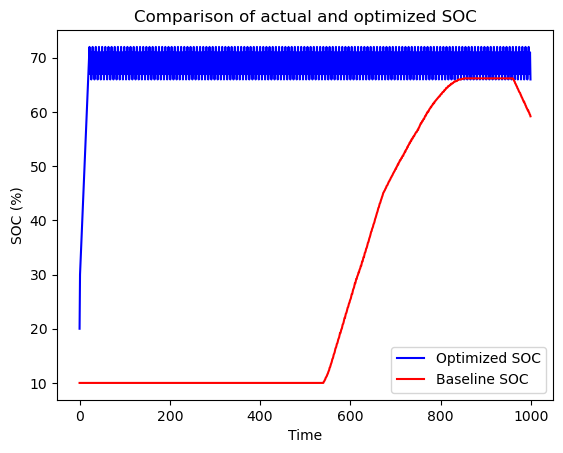

In [114]:


plt.plot(opt_socs[:1000],label='Optimized SOC', color='blue')
plt.plot(socs[:1000],label='Baseline SOC', color='red')
plt.title('Comparison of actual and optimized SOC')
plt.xlabel('Time')
plt.ylabel('SOC (%)')
plt.legend()

In [186]:
np.sum(np.asarray(opt_socs)>80), np.sum(np.asarray(socs)>80)

(1298, 399)

In [188]:
np.sum(np.asarray(opt_socs)<20), np.sum(np.asarray(socs)<20)

(3301, 13505)